In [1]:
print('hello world')

hello world


In [2]:
import torch
torch.__version__

'1.13.1'

In [3]:
torch.cuda.device_count()
device = torch.device('cuda:5') if torch.cuda.is_available() else "cpu"
device
# torch.cuda.get_device_name(device=device)

device(type='cuda', index=5)

In [4]:
import re
from typing import Dict, List, Tuple
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from pathlib import Path
import random
import numpy as np
import pandas as pd
import pathlib
from PIL import Image

num_workers = 2
data_path = Path("/local/scratch/camelyon17/camelyon17_v1.0/patches")
batch_size = 32
total_samples, num_samples = 0, 0
seed = 42
num_clients = 5
df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
num_test_clients = 1


In [5]:
from typing import Sequence, TypeVar
import froodo.quickstart as fr


T_co = TypeVar("T_co", covariant=True)

class SubsetOOD(Dataset[T_co]):
    r"""
    Subset of a dataset at specified indices.

    Args:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """

    dataset: Dataset[T_co]
    indices: Sequence[int]

    def __init__(self, dataset: Dataset[T_co], indices: Sequence[int]) -> None:
        self.dataset = dataset
        self.indices = indices
        self.augs = [fr.DarkSpotsAugmentation(1), fr.FatAugmentation(1), fr.SquamousAugmentation(1), fr.ThreadAugmentation(1), fr.GaussianBlurAugmentation(sigma=5)]


    def __getitem__(self, idx):
        aug = random.choose(self.augs)
        return ((aug(fr.Sample(image=self.dataset[self.indices[idx]][0]))).image, self.dataset[self.indices[idx]][1])

    def __getitems__(self, indices: List[int]) -> List[T_co]:
        # add batched sampling support when parent dataset supports it.
        # see torch.utils.data._utils.fetch._MapDatasetFetcher
        if callable(getattr(self.dataset, "__getitems__", None)):
            return self.dataset.__getitems__([self.indices[idx] for idx in indices])  # type: ignore[attr-defined]
        else:
            aug = [random.choice(self.augs) for i in range(len(indices))]
            return [((aug[idx](fr.Sample(image=self.dataset[self.indices[idx]][0]))).image, self.dataset[self.indices[idx]][1]) for idx in indices]

    def __len__(self):
        return len(self.indices)

In [6]:
def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = ["Non-cancerous", "Cancerous"]
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# Write a custom dataset class (inherits from torch.utils.data.Dataset)

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.png")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
        # for idx in range(len(self.paths)):
        #     image_path = self.paths[idx]
        #     regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        #     mo=regex.search(str(image_path)[69:])
        #     patient,node,x,y = mo.groups()
        #     patient,node,x,y = int(patient), int(node), int(x), int(y)
        #     self.center[idx] = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0])


        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        img = img.convert("RGB")
        img_arr = np.asarray(img)
        img = Image.fromarray(img_arr)
        image_path = self.paths[index]
        regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        mo=regex.search(str(image_path)[69:])
        # print(mo.groups())
        patient,node,x,y = mo.groups()
        patient,node,x,y = int(patient), int(node), int(x), int(y)

        has_cancer = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["tumor"].iloc[0])     
        class_name  = "Cancerous" if has_cancer else "Non-cancerous" # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


def create_dataloaders(data_transform: transforms.Compose):
    random.seed(seed)

    paths = list(pathlib.Path(data_path).glob("*/*.png")) # note: you'd have to update this if you've got .png's or .jpeg's
    # print(len(paths))
    center = []
    # # Setup transforms
    df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
    regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
    for idx in range(len(paths)):
        image_path = paths[idx]
        mo=regex.search(str(image_path)[69:])
        patient,node,x,y = mo.groups()
        patient,node,x,y = int(patient), int(node), int(x), int(y)
        center.append(int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0]))

    indices_subsets = {0:[],1:[],2:[],3:[],4:[],}

    for i in range(len(center)):
        indices_subsets[center[i]].append(i)
    
    for (key, value) in indices_subsets.items():
        random.shuffle(indices_subsets[key])
    

    data = ImageFolderCustom(
        targ_dir = data_path,
        transform = data_transform
    )

    total_samples = len(data)
    num_samples = total_samples


    train_indices=[]
    validate_indices=[]
    test_indices=[]

    train_client_indices = [0,1,3,4]
    ood_client_indices = [3]

    for i in range(num_clients):
        if(i in train_client_indices):
            train_split = int(0.8*len(indices_subsets[i]))
            train_indices.append(indices_subsets[i][0:train_split])
            validate_indices.append(indices_subsets[i][train_split:])
        else:
            test_indices.append(indices_subsets[i])

    train_datasets = []
    validate_datasets = []
    test_datasets = []

    tr_idx, te_idx = 0,0
    for i in range(num_clients):
        if(i in train_client_indices):
            if(i in ood_client_indices):
                train_datasets.append(SubsetOOD(data, train_indices[tr_idx]))
                validate_datasets.append(SubsetOOD(data, validate_indices[tr_idx]))
                tr_idx+=1
            else:
                train_datasets.append(Subset(data, train_indices[tr_idx]))
                validate_datasets.append(Subset(data, validate_indices[tr_idx]))
                tr_idx+=1
        else:
            test_datasets.append(Subset(data, test_indices[te_idx]))
            te_idx+=1
    
    train_dataloaders = []
    validate_dataloaders = []
    test_dataloaders = []

    tr_idx, te_idx = 0,0


    for i in range(num_clients):
        if(i in train_client_indices):
            train_dataloaders.append(
                DataLoader(
                    dataset = train_datasets[tr_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
            ))

            validate_dataloaders.append(
                DataLoader(
                    dataset = validate_datasets[tr_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )

            tr_idx += 1

        else:
            test_dataloaders.append(
                DataLoader(
                    dataset = test_datasets[te_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )
            te_idx += 1

    return train_dataloaders, validate_dataloaders, test_dataloaders
    


In [7]:
data = ImageFolderCustom(
    targ_dir = data_path,
    transform = transforms.ToTensor()
)


In [16]:
ind  = [i for i in range(32)]
l = SubsetOOD(data, ind)

In [17]:
p = DataLoader(
    dataset=l,
    batch_size=32,
    shuffle=True
)

In [32]:
img,label=next(iter(p))

tensor(0)

In [33]:
img[0].shape

torch.Size([3, 96, 96])

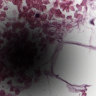

In [34]:
Image.fromarray((img[0].permute(1,2,0)*255).numpy().astype(np.uint8))